# Preparation



### Unzip the dataset

In [3]:
# unzip the zip dataset
import zipfile
!unzip /content/sample_data/a.zip

Archive:  /content/sample_data/a.zip
replace Classification_Dataset/test/IMG_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Importing libraries

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import os
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow v2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

TensorFlow 2.x selected.


# Upload and preprocessing



In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

### Create generators to read images from dataset directory

In [42]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Classification_Dataset')

# img

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

num_classes=20

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               classes=['owl', 'galaxy','lightning', 'wine-bottle', 't-shirt', 'waterfall', 'sword', 'school-bus', 'calculator', 'sheet-music', 'airplanes', 'lightbulb', 'skyscraper', 'mountain-bike', 'fireworks', 'computer-monitor', 'bear', 'grand-piano', 'kangaroo', 'laptop'],
                                               batch_size=bs,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=bs,
                                             
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=SEED)

Found 1554 images belonging to 20 classes.
Found 0 images belonging to 0 classes.


Test and visualize the dataset

In [19]:
print (train_gen)

Adding the validation dataset

In [0]:
# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)


## Create Dataset objects

In [0]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
test_dataset = valid_dataset.repeat()

### Data augmentation

In [0]:
# Let's test data augmentation
# ----------------------------
import time
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure()
ax = fig.gca()
fig.show()

iterator = iter(train_dataset)

for _ in range(1000):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img * 255  # denormalize
    
    plt.imshow(np.uint8(augmented_img))
    fig.canvas.draw()
    time.sleep(1)

# Processing


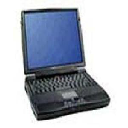

InvalidArgumentError: ignored

In [18]:
iterator = iter(train_dataset)
sample, target = next(iterator)
# Just for visualization purpouses
sample = sample[0, ...]  # select first image in the batch
sample = sample * 255  # denormalize

from PIL import Image
img = Image.fromarray(np.uint8(sample))
img = img.resize([128, 128])
img

target[1]  # select corresponding target

In [0]:
# Fashion MNIST classification
# ----------------------------

# x: 28x28
# y: 10 classes

# Create Model
# ------------
# e.g. in: 28x28 -> h: 10 units -> out: 10 units (number of classes) 

# Define Input keras tensor
x = tf.keras.Input(shape=[28, 28])

# Define intermediate hidden layers and chain
flatten = tf.keras.layers.Flatten()(x)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.sigmoid)(flatten)

# Define output layer and chain
out = tf.keras.layers.Dense(units=20, activation=tf.keras.activations.softmax)(h)

# Create Model instance defining inputs and outputs
model = tf.keras.Model(inputs=x, outputs=out)

In [24]:
# Visualize created model as a table
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Visualize initialized weights
model.weights

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [46]:
model.fit(x=train_dataset,  # you can give directly numpy arrays x_train
          y=None,   # if x is a Dataset y has to be None, y_train otherwise
           validation_split=0.3,  # give a validation Dataset if you created it manually, otherwise you can use 'validation_split' for automatic split
          epochs=10, 
          steps_per_epoch=int(np.ceil(1554 / bs)),  # how many batches per epoch
          validation_steps=10000)  # number of batches in validation set

ValueError: ignored